In [64]:
# Load all_teams_performance_data.csv into a pandas dataframe
import pandas as pd
df = pd.read_csv('all_teams_performance_data.csv')
# Add new column called year which is the first 4 characters of the event_key column
df['year'] = df['event_key'].str[:4].astype(int)
df = df[df['year'] != 2020]
df = df[(df['opr'].notnull()) & (df['week'].notnull())]
max_opr_per_year = df.groupby('year')['opr'].transform(lambda x: x.nlargest(1).mean())
df.loc[:, 'normalized_opr'] = df['opr'] / max_opr_per_year

In [65]:
def get_df(year=None, weeks=None, state_prov=None):
    df_filtered = df.copy()
    
    if year is not None:
        df_filtered = df_filtered[df_filtered['year'].isin(year)]
    
    if weeks is not None:
        df_filtered = df_filtered[df_filtered['week'].isin(weeks)]
    
    if state_prov is not None:
        df_filtered = df_filtered[df_filtered['state_prov'] == state_prov]
    
    return df_filtered

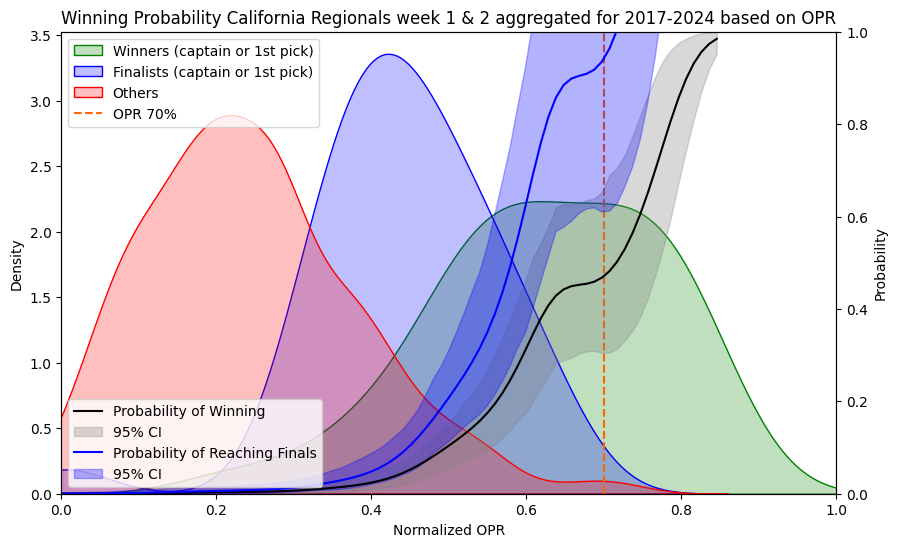

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.utils import resample

def plot_opr_distribution_with_bootstrap(df, n_bootstrap=1000):
    if df.empty:
        print('Dataframe is empty')
        return

    years = df['year'].unique()
    opr_70 = 0.7

    # Assuming in_season_2017_df is your DataFrame
    won_pick_teams = df[(df['status'] == 'winner') & (df['pick'] <= 1)]
    finalist_pick_teams = df[(df['status'] == 'finalist') & (df['pick'] <= 1)]
    other_teams = df[~((df['status'] == 'winner') & (df['pick'] <= 1))]

    # Define the OPR target
    opr_target = opr_70

    # Define a range of OPR values
    opr_values = np.linspace(df['normalized_opr'].min(), df['normalized_opr'].max(), 100)

    # Initialize arrays to store bootstrap results
    bootstrap_probabilities = np.zeros((n_bootstrap, len(opr_values)))

    # Perform bootstrapping
    for i in range(n_bootstrap):
        # Resample the data with replacement
        df_resampled = resample(df)

        # Split the resampled data into winning and other teams
        won_pick_teams_resampled = df_resampled[(df_resampled['status'] == 'winner') & (df_resampled['pick'] <= 1)]
        finalist_pick_teams_resampled = df_resampled[(df_resampled['status'] == 'finalist') & (df_resampled['pick'] <= 1)]
        other_teams_resampled = df_resampled[~((df_resampled['status'] == 'winner') & (df_resampled['pick'] <= 1))]

        # Calculate the KDE using scipy.stats.gaussian_kde
        kde_won = gaussian_kde(won_pick_teams_resampled['normalized_opr'])
        kde_finalist = gaussian_kde(finalist_pick_teams_resampled['normalized_opr'])
        kde_other = gaussian_kde(other_teams_resampled['normalized_opr'])

        # Evaluate the KDE at the range of OPR values
        density_won = kde_won(opr_values)
        density_finalist = kde_finalist(opr_values)
        density_other = kde_other(opr_values)

        # Calculate the proportion of teams in each group
        proportion_won = len(won_pick_teams_resampled) / len(df_resampled)
        proportion_finalist = len(finalist_pick_teams_resampled) / len(df_resampled)
        proportion_other = len(other_teams_resampled) / len(df_resampled)

        # Adjust the densities by the proportions
        adjusted_density_won = density_won * proportion_won
        adjusted_density_finalist = density_finalist * proportion_finalist
        adjusted_density_other = density_other * proportion_other

        # Calculate the winning probability for each OPR value
        total_density = adjusted_density_won + adjusted_density_other + adjusted_density_finalist
        probability_winning = adjusted_density_won / total_density

        # Store the results
        bootstrap_probabilities[i, :] = probability_winning

    # Calculate the mean and confidence intervals
    mean_probability_winning = np.mean(bootstrap_probabilities, axis=0)
    lower_ci = np.percentile(bootstrap_probabilities, 2.5, axis=0)
    upper_ci = np.percentile(bootstrap_probabilities, 97.5, axis=0)

    # Plot the KDE and the winning probability
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the KDE
    sns.kdeplot(won_pick_teams['normalized_opr'], color='g', label='Winners (captain or 1st pick)', fill=True, ax=ax1)
    sns.kdeplot(finalist_pick_teams['normalized_opr'], color='b', label='Finalists (captain or 1st pick)', fill=True, ax=ax1)
    sns.kdeplot(other_teams['normalized_opr'], color='r', label='Others', fill=True, ax=ax1)

    # Add vertical line for OPR target
    ax1.axvline(round(opr_target, 2), color='#ff6600', linestyle='--', label='OPR 70%')

    # Add labels and title
    ax1.set_xlabel('Normalized OPR')
    ax1.set_ylabel('Density')
    #ax1.set_title('Distribution of Normalized OPR in {}'.format(years))
    ax1.set_title('Winning Probability California Regionals week 1 & 2 aggregated for 2017-2024 based on OPR')

    # Add a legend
    ax1.legend(loc='upper left')

    # Limit the x-axis to 1.0
    ax1.set_xlim(0, 1.0)

    # Create a second y-axis for the probabilities of winning and for finals probability (winner or finalist)
    ax2 = ax1.twinx()

    # Plot the winning probability
    ax2.plot(opr_values, mean_probability_winning, color='k', label='Probability of Winning')
    ax2.fill_between(opr_values, lower_ci, upper_ci, color='gray', alpha=0.3, label='95% CI')

    # probability of reaching finals
    probability_finals = mean_probability_winning + np.mean(bootstrap_probabilities, axis=0)
    ax2.plot(opr_values, probability_finals, color='b', label='Probability of Reaching Finals')
    ax2.fill_between(opr_values, lower_ci + np.percentile(bootstrap_probabilities, 2.5, axis=0), upper_ci + np.percentile(bootstrap_probabilities, 97.5, axis=0), color='blue', alpha=0.3, label='95% CI')

    # Add labels
    ax2.set_ylabel('Probability')
    ax2.set_ylim(0, 1.0)
    
    # Add a legend
    ax2.legend(loc='lower left')

    # Show the plot
    plt.show()

# Example usage:
plot_opr_distribution_with_bootstrap(get_df(year=[2017,2018,2019,2022,2023,2024], weeks=[1,2], state_prov='CA'), n_bootstrap=100)

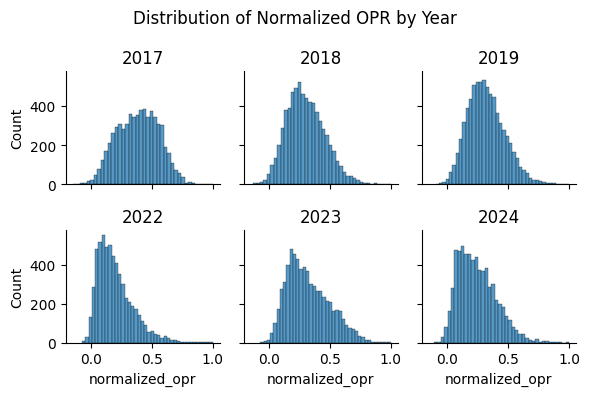

In [ ]:
import pandas as pd
import seaborn as sns

# Show a histogram of normalized OPR for each year from 2017 to 2024 (use a facet grid)
df_temp = df.copy()

# Create a FacetGrid
g = sns.FacetGrid(df_temp, col='year', col_wrap=3, height=2)

# Map a histogram to each year
g.map(sns.histplot, 'normalized_opr', bins=40, kde=False)

# Add a title to the overall plot
g.fig.suptitle('Distribution of Normalized OPR by Year')
g.fig.subplots_adjust(top=0.85)

# Add titles to each plot
for ax, title in zip(g.axes.flat, ['2017', '2018', '2019', '2022', '2023', '2024']):
    ax.set_title(title)

# add some space between the plots vertically
plt.tight_layout()

# Show the plot
plt.show()

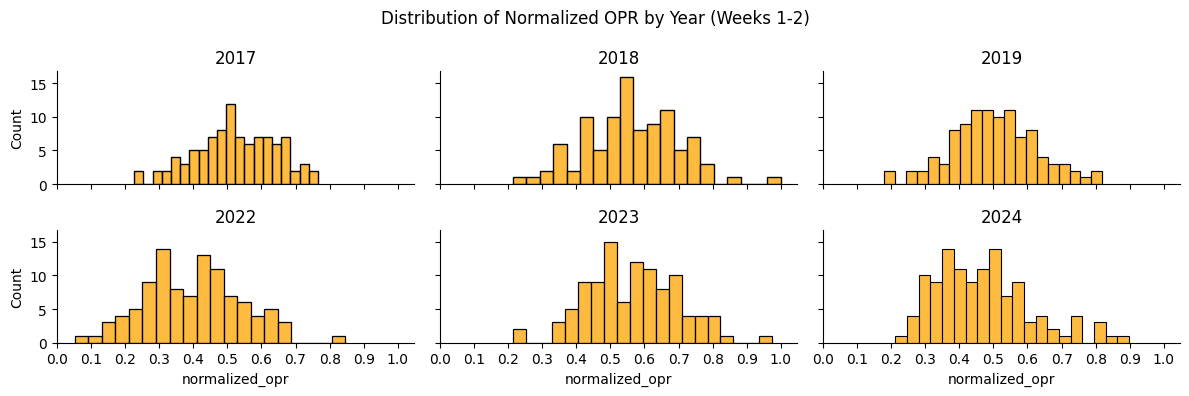

In [156]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Make same plot but only for winners (first pick or captain)
# Show a histogram of normalized OPR for each year from 2017 to 2024 (use a facet grid)
df_temp = df.copy()
df_temp = df_temp[df_temp['status'] == 'won']
df_temp = df_temp[df_temp['pick'] <= 1]
df_temp = df_temp[df_temp['week'] <= 1]

# Create a FacetGrid with increased width
g = sns.FacetGrid(df_temp, col='year', col_wrap=3, height=2, aspect=2)

# Map a histogram to each year
g.map(sns.histplot, 'normalized_opr', bins=20, kde=False, color='orange')

# Add a title to the overall plot
g.fig.suptitle('Distribution of Normalized OPR by Year (Weeks 1-2)')
g.fig.subplots_adjust(top=0.85)

# Add titles to each plot
for ax, title in zip(g.axes.flat, ['2017', '2018', '2019', '2022', '2023', '2024']):
    ax.set_title(title)
    ax.set_xticks(np.arange(0, 1.1, 0.1))

# add some space between the plots vertically
plt.tight_layout()

# Show the plot
plt.show()

In [9]:
# I want to write a script that plots the map of the US with the states colored based on an arbitrary value

# make Choropleth map
import plotly.express as px

df_new = df.copy()
# Also only get week 1 or 2 data
# df_new = df_new[df_new['week'].isin([0, 1])]

# Filter the data on normalized OPR above or equal to 70%
df_new = df_new[df_new['normalized_opr'] >= 0.7]

# Calculate the average amount of teams with a normalized OPR above 70% per event per state (aggregate the events per state)
state_stats = df_new.groupby(['state_prov', 'event_key']).size().reset_index(name='count')
state_stats = state_stats.groupby('state_prov')['count'].mean().reset_index()


# Create a Choropleth map
fig = px.choropleth(state_stats, 
                    locations='state_prov',
                    locationmode='USA-states',
                    color='count',
                    scope='usa',
                    color_continuous_scale='Oranges',
                    title='70% OPR teams per state',)
fig.show()

# Make a list of teams that reached the 70% OPR threshold. put it in a table with the team number, event key, and normalized OPR
teams = df_new[['team_key', 'event_key', 'normalized_opr', 'opr', 'state_prov', 'year', 'week']]
teams = teams.sort_values('year', ascending=True)
teams = teams.reset_index(drop=True)

# Save the table to a csv file
teams.to_csv('teams_above_70_opr.csv', index=False)


C:\Users\20213116\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:718: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.

C:\Users\20213116\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:854: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\20213116\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:854: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\20213116\Ap

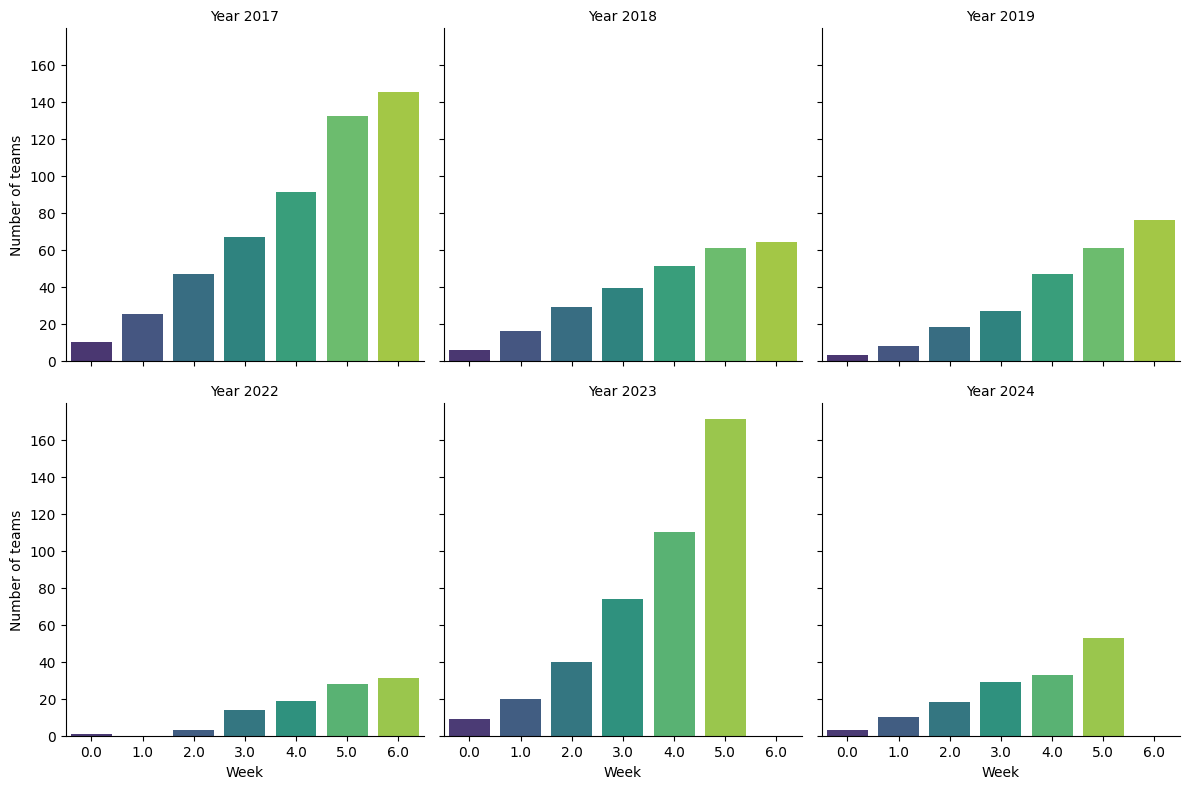

    year  week  count
0   2017   0.0     10
1   2017   1.0     25
2   2017   2.0     47
3   2017   3.0     67
4   2017   4.0     91
5   2017   5.0    132
6   2017   6.0    145
7   2018   0.0      6
8   2018   1.0     16
9   2018   2.0     29
10  2018   3.0     39
11  2018   4.0     51
12  2018   5.0     61
13  2018   6.0     64
14  2019   0.0      3
15  2019   1.0      8
16  2019   2.0     18
17  2019   3.0     27
18  2019   4.0     47
19  2019   5.0     61
20  2019   6.0     76
21  2022   0.0      1
22  2022   2.0      3
23  2022   3.0     14
24  2022   4.0     19
25  2022   5.0     28
26  2022   6.0     31
27  2023   0.0      9
28  2023   1.0     20
29  2023   2.0     40
30  2023   3.0     74
31  2023   4.0    110
32  2023   5.0    171
33  2024   0.0      3
34  2024   1.0     10
35  2024   2.0     18
36  2024   3.0     29
37  2024   4.0     33
38  2024   5.0     53


In [10]:
# make a grid of bar plots showing the amount of teams with normalized OPR above 70% for each week per year
# Make sure that each team_key is only counted once per year and that the bar plot is cumulative
# So that if a team competes in week 1 and week 2, it is only counted once in week 1 and not in week 2 but the count for week 2 is the sum of week 1 and week 2
import matplotlib.pyplot as plt
import seaborn as sns

# use df_new
df_new = df.copy()

# Filter the data on normalized OPR above or equal to 70%
df_new = df_new[df_new['normalized_opr'] >= 0.7]

# Calculate the amount of teams with a normalized OPR above 70% per week per year
teams_per_week = df_new.groupby(['year', 'week', 'team_key']).size().reset_index(name='count')
teams_per_week = teams_per_week.groupby(['year', 'week']).size().groupby(level=0).cumsum().reset_index(name='count')

# Create a grid of bar plots
g = sns.FacetGrid(teams_per_week, col='year', col_wrap=3, height=4)
g.map(sns.barplot, 'week', 'count', palette='viridis')
g.set_axis_labels('Week', 'Number of teams')
g.set_titles('Year {col_name}')
g.tight_layout()
plt.show()

# Print all team_keys with their week and year that were used in the bar plots (to check if the bar plots are correct)
print(teams_per_week)

In [84]:
import pandas as pd
import numpy as np
from sklearn.utils import resample

def downsample_majority_class(df, target_column, n_iterations=100):
    # Separate majority and minority classes
    majority_class = df[df[target_column] == 0]
    minority_class = df[df[target_column] == 1]

    # Initialize a list to store the resampled datasets
    resampled_datasets = []

    for _ in range(n_iterations):
        # Downsample majority class
        majority_downsampled = resample(majority_class, 
                                        replace=False,    # sample without replacement
                                        n_samples=len(minority_class),  # match minority class
                                        random_state=None)  # different random seed each iteration

        # Combine minority class with downsampled majority class
        resampled_df = pd.concat([minority_class, majority_downsampled])

        # Append the resampled dataset to the list
        resampled_datasets.append(resampled_df)

    # Concatenate all resampled datasets
    combined_resampled_df = pd.concat(resampled_datasets)

    # Shuffle the combined dataset
    combined_resampled_df = combined_resampled_df.sample(frac=1).reset_index(drop=True)

    return combined_resampled_df

In [91]:
data = df.copy()

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import time

# Preprocessing
# only use data with week 1 or 2
""" data = data[data['week'].isin([0, 1])] """

# get all events where there are exactly 8 teams with a last_year_norm_epa value above 1600
""" events_with_8_teams_above_1600 = data[data['last_year_norm_epa'] > 1600].groupby('event_key').filter(lambda x: len(x) in [6,7,8,9,10,11,12])['event_key'].unique()
print(events_with_8_teams_above_1600)
data = data[data['event_key'].isin(events_with_8_teams_above_1600)] """



data['status'] = data['status'].fillna('eliminated')
# if status is 'won' but pick is 2 or higher, change status to 'eliminated'
data.loc[(data['status'] == 'won') & (data['pick'] > 1), 'status'] = 'eliminated'
data.loc[data['status'] == 'finalist', 'status'] = 'winner'
data['status'] = LabelEncoder().fit_transform(data['status'])  # Encode "won" = 1, others = 0
data['pick'] = data['pick'].fillna(999)
data['alliance'] = data['alliance'].fillna(999)
data['year'] = data['year'].astype(float)

# Drop rows with NaN values in last_year_norm_epa
data = data.dropna(subset=['last_year_norm_epa'])

# Define X and Y
X = data[['normalized_opr', 'last_year_norm_epa']]
Y = data['status']

# Make sure that the data is balanced (equal amount of winners and others) by downsampling the majority class
# Separate majority and minority classes
df_majority = data[data['status'] == 0]
df_minority = data[data['status'] == 1]

# Downsample the majority class
df_majority_downsampled = downsample_majority_class(data, 'status', n_iterations=100)

# Define X and Y
X = df_majority_downsampled[['normalized_opr', 'last_year_norm_epa']]
Y = df_majority_downsampled['status']

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

def print_accuracy(f):
    print(f"Accuracy = {100 * np.sum((f(X_test) == Y_test) & (Y_test == 1)) / np.sum(Y_test == 1)}%")
    time.sleep(0.5)  # to let the print get out before any progress bars

In [92]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, Y_train)
print_accuracy(model.predict)


Accuracy = 67.33482654335641%


C:\Users\20213116\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


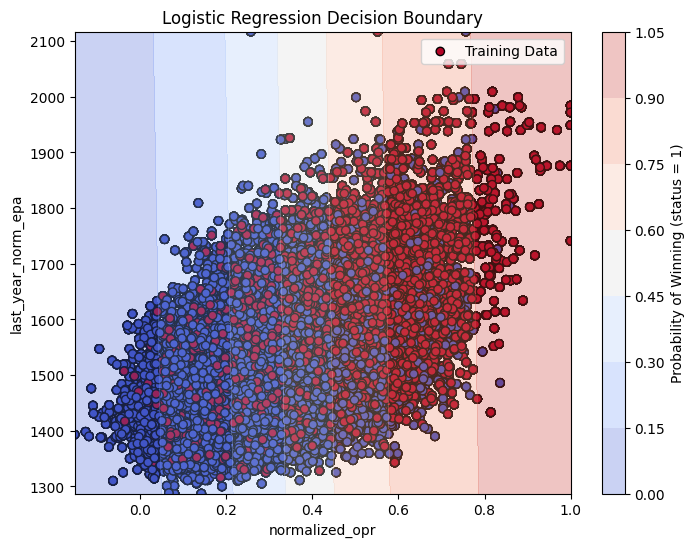

In [93]:
import matplotlib.pyplot as plt
import numpy as np

# Create a grid of values for plotting the decision boundary
x1_vals = np.linspace(X_train['normalized_opr'].min(), X_train['normalized_opr'].max(), 100)
x2_vals = np.linspace(X_train['last_year_norm_epa'].min(), X_train['last_year_norm_epa'].max(), 100)
x1_grid, x2_grid = np.meshgrid(x1_vals, x2_vals)
grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

# Predict probabilities for the grid
y_vals = model.predict_proba(grid)[:, 1].reshape(x1_grid.shape)  # Probability of class 1 (won)

# Plot the decision boundary
plt.figure(figsize=(8, 6))
plt.scatter(X_train['normalized_opr'], X_train['last_year_norm_epa'], c=Y_train, cmap=plt.cm.coolwarm, edgecolors='k', label='Training Data')
plt.contourf(x1_grid, x2_grid, y_vals, alpha=0.3, cmap=plt.cm.coolwarm)
plt.colorbar(label='Probability of Winning (status = 1)')

# Add labels and title
plt.title("Logistic Regression Decision Boundary")
plt.xlabel("normalized_opr")
plt.ylabel("last_year_norm_epa")
plt.legend()
plt.show()


Teams with NaN value for last_year_norm_epa:
frc9402
frc9404
frc9693
frc9725
frc9779


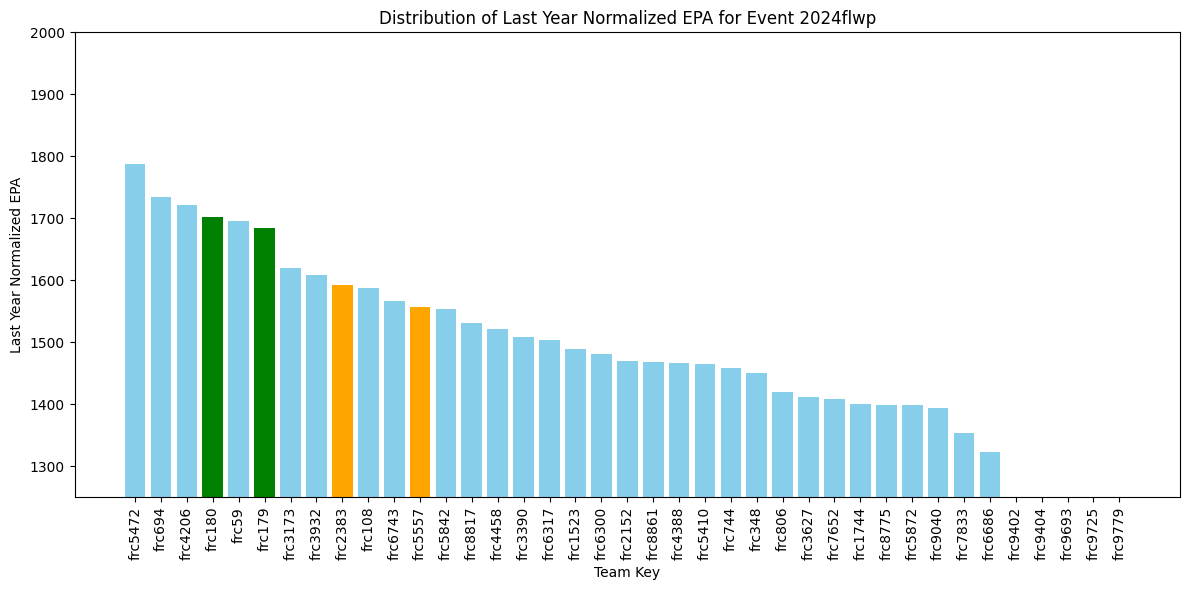

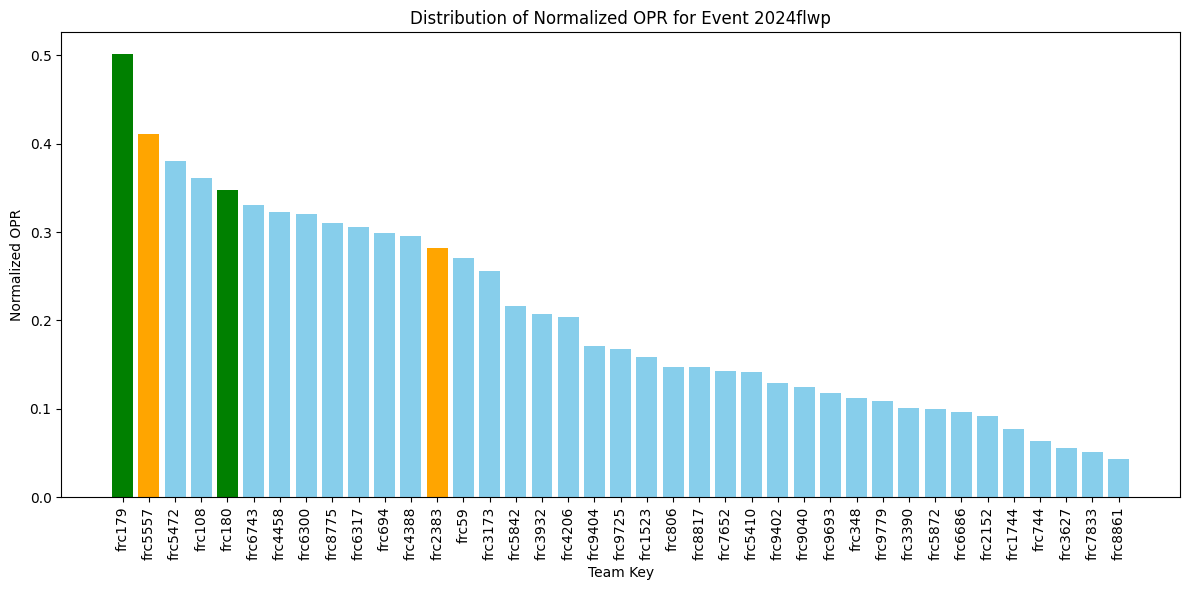

In [60]:
df_temp = df.copy()

import matplotlib.pyplot as plt

# Each event has a different distribution of last_year_norm_epa team performance. some events contain a lot of teams that were very good last year, while others contain very few.
# I want to create a bar plot that shows the distribution of last_year_norm_epa for a specific event_key

# Filter the data on a specific event_key
event_key = '2024flwp'
df_temp = df_temp[df_temp['event_key'] == event_key]

# Print teams with NaN value for last_year_norm_epa
dropped_teams = df_temp[df_temp['last_year_norm_epa'].isna()]['team_key']
print("Teams with NaN value for last_year_norm_epa:")
for team in dropped_teams:
    print(team)

# rows with NaN values for last_year_norm_epa get value 1500 (base line value) but get a different color in the bar plot
df_temp['last_year_norm_epa'] = df_temp['last_year_norm_epa'].fillna(0)

df_temp = df_temp.sort_values('last_year_norm_epa', ascending=False)

# Teams with status 'winner' or 'finalist' with value pick = 2 are set to status eliminated
df_temp.loc[(df_temp['status'] == 'winner') & (df_temp['pick'] > 1), 'status'] = 'eliminated'
df_temp.loc[(df_temp['status'] == 'finalist') & (df_temp['pick'] > 1), 'status'] = 'eliminated'

# Assign colors based on the 'status' column
colors = df_temp['status'].apply(lambda x: 'green' if x == 'winner' else 'orange' if x == 'finalist' else 'skyblue')

# Create a bar plot where each bar represents one team and the height of the bar is the last_year_norm_epa value
plt.figure(figsize=(12, 6))
plt.bar(df_temp['team_key'], df_temp['last_year_norm_epa'], color=colors)
plt.xlabel('Team Key')
plt.ylabel('Last Year Normalized EPA')
plt.title(f'Distribution of Last Year Normalized EPA for Event {event_key}')
plt.xticks(rotation=90)
plt.ylim(1250, 2000)
plt.tight_layout()
plt.show()

df_temp = df_temp.sort_values('normalized_opr', ascending=False)

colors = df_temp['status'].apply(lambda x: 'green' if x == 'winner' else 'orange' if x == 'finalist' else 'skyblue')

# Create a bar plot where each bar represents one team and the height of the bar is the normalized_opr value
plt.figure(figsize=(12, 6))
plt.bar(df_temp['team_key'], df_temp['normalized_opr'], color=colors)
plt.xlabel('Team Key')
plt.ylabel('Normalized OPR')
plt.title(f'Distribution of Normalized OPR for Event {event_key}')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [117]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns

df_temp = df.copy()

# Filter events with at least 10 teams
df_temp = df_temp.groupby('event_key').filter(lambda x: len(x) >= 10)

C:\Users\20213116\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


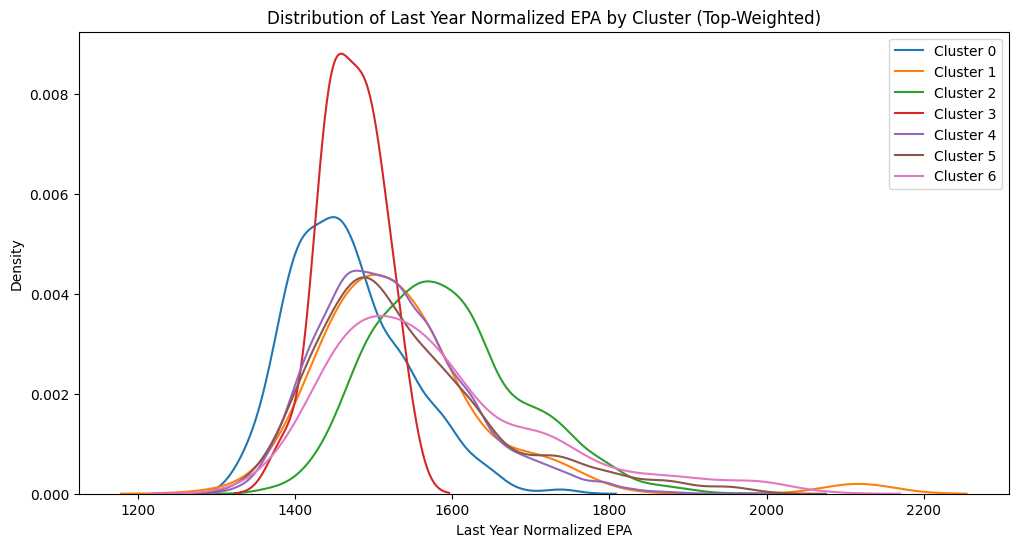

C:\Users\20213116\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


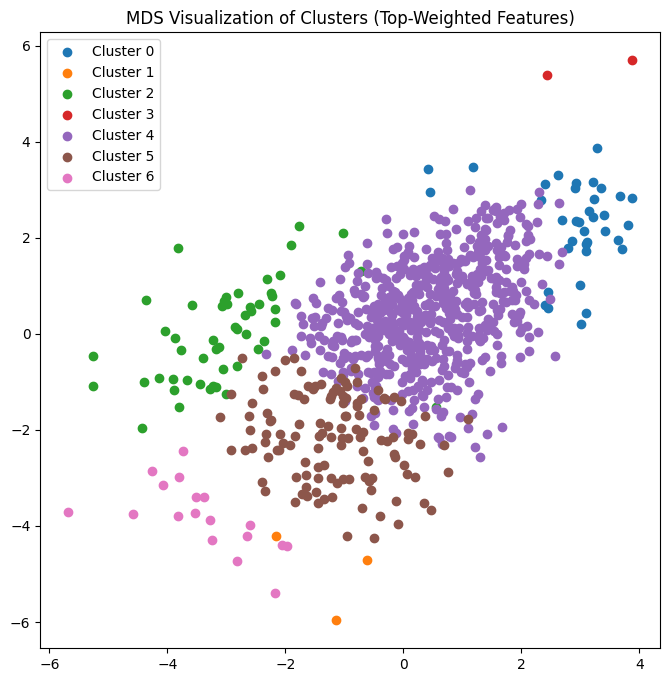

In [118]:
# Focus on top teams: custom features for high EPA values
features = []
top_threshold = 1700  # Example threshold for "very good" teams

for event_key, group in df_temp.groupby('event_key'):
    values = group['last_year_norm_epa'].dropna()
    if len(values) == 0:
        continue
    sorted_values = np.sort(values)[::-1]  # Sort in descending order
    top_5_percent = sorted_values[:max(1, int(0.05 * len(values)))]  # Top 5% teams
    features.append({
        'event_key': event_key,
        'max_epa': values.max(),
        'mean_top_5_percent': top_5_percent.mean() if len(top_5_percent) > 0 else 0,
        'count_above_threshold': (values > top_threshold).sum(),
        'mean': values.mean(),
        'std': values.std(),
    })

# Convert to DataFrame
features_df = pd.DataFrame(features).set_index('event_key')

# Normalize features to avoid scale issues
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features_df)

# Use Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering
distance_matrix = pairwise_distances(normalized_features, metric='euclidean')

n_clusters = 7  # Adjust as needed
cluster_model = AgglomerativeClustering(
    n_clusters=n_clusters, affinity="precomputed", linkage="average"
)
clusters = cluster_model.fit_predict(distance_matrix)

# Assign clusters back to the original DataFrame
features_df['cluster'] = clusters

# Visualize cluster distributions
plt.figure(figsize=(12, 6))
for cluster in range(n_clusters):
    sns.kdeplot(
        df_temp[df_temp['event_key'].map(features_df['cluster']) == cluster]['last_year_norm_epa'],
        label=f'Cluster {cluster}',
        fill=False,
    )
plt.xlabel('Last Year Normalized EPA')
plt.ylabel('Density')
plt.title('Distribution of Last Year Normalized EPA by Cluster (Top-Weighted)')
plt.legend()
plt.show()

# MDS Visualization
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
mds_coords = mds.fit_transform(distance_matrix)

plt.figure(figsize=(8, 8))
for cluster in range(n_clusters):
    cluster_points = mds_coords[clusters == cluster]
    plt.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        label=f'Cluster {cluster}',
    )
plt.title("MDS Visualization of Clusters (Top-Weighted Features)")
plt.legend()
plt.show()


             mean  median  max  count
cluster                              
0        0.138889     0.0    1     36
1        3.666667     3.0    5      3
2        6.254902     6.0   11     51
3        0.000000     0.0    0      2
4        1.754153     2.0    5    602
5        3.829268     4.0    7    123
6        6.833333     6.5   12     18


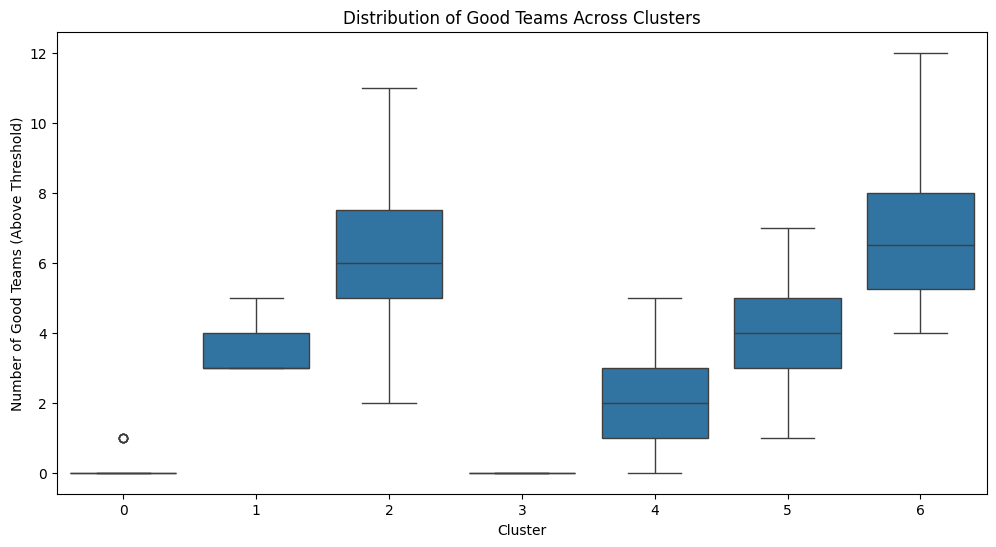

In [119]:
# Add cluster information back to the features DataFrame
features_df['cluster'] = clusters

# Analyze clusters based on 'count_above_threshold'
cluster_summary = features_df.groupby('cluster')['count_above_threshold'].agg(['mean', 'median', 'max', 'count'])

# Print the summary for interpretation
print(cluster_summary)

# Visualize distribution of 'count_above_threshold' across clusters
plt.figure(figsize=(12, 6))
sns.boxplot(data=features_df, x='cluster', y='count_above_threshold')
plt.xlabel('Cluster')
plt.ylabel('Number of Good Teams (Above Threshold)')
plt.title('Distribution of Good Teams Across Clusters')
plt.show()


In [128]:
# save the supdataset with only events of cluster 2 and 6
df_good = df_temp[df_temp['event_key'].isin(features_df[features_df['cluster'].isin([1,2,5,6])].index)]

In [145]:
data = df.copy()

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import time

# Preprocessing

# only use 2022-2024 data

# only use data with week 1 or 2
data = data[data['week'].isin([1])]

data['status'] = data['status'].fillna('eliminated')
# if status is 'won' but pick is 2 or higher, change status to 'eliminated'
data.loc[(data['status'] == 'won') & (data['pick'] > 1), 'status'] = 'eliminated'
#data.loc[data['status'] == 'finalist', 'status'] = 'winner'
data['status'] = LabelEncoder().fit_transform(data['status'])  # Encode "won" = 1, others = 0
data['pick'] = data['pick'].fillna(999)
data['alliance'] = data['alliance'].fillna(999)
data['year'] = data['year'].astype(float)

# Drop rows with NaN values in last_year_norm_epa
data = data.dropna(subset=['last_year_norm_epa'])

# Define X and Y
X = data[['normalized_opr', 'last_year_norm_epa']]
Y = data['status']

# Make sure that the data is balanced (equal amount of winners and others) by downsampling the majority class
# Separate majority and minority classes
df_majority = data[data['status'] == 0]
df_minority = data[data['status'] == 1]

# Downsample the majority class
df_majority_downsampled = downsample_majority_class(data, 'status', n_iterations=100)

# Define X and Y
X = df_majority_downsampled[['normalized_opr', 'last_year_norm_epa']]
Y = df_majority_downsampled['status']

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

def print_accuracy(f):
    print(f"Accuracy = {100 * np.sum((f(X_test) == Y_test) & (Y_test == 1)) / np.sum(Y_test == 1)}%")
    time.sleep(0.5)  # to let the print get out before any progress bars

In [146]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, Y_train)
print_accuracy(model.predict)

Accuracy = 66.59222867351497%


C:\Users\20213116\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


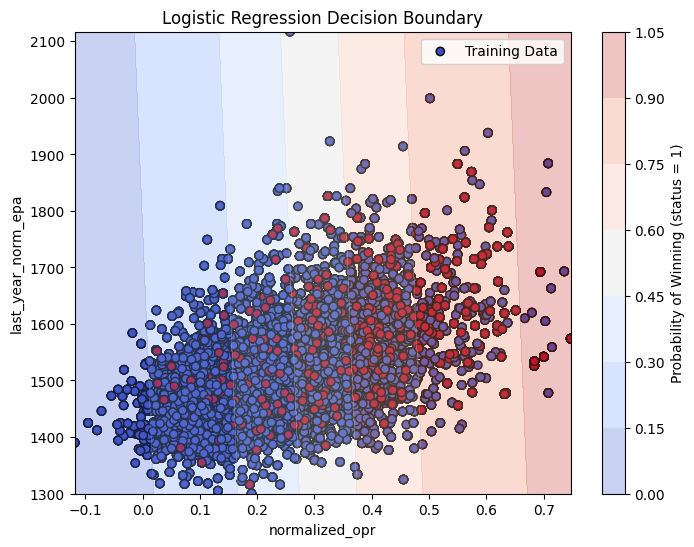

In [147]:
import matplotlib.pyplot as plt
import numpy as np

# Create a grid of values for plotting the decision boundary
x1_vals = np.linspace(X_train['normalized_opr'].min(), X_train['normalized_opr'].max(), 100)
x2_vals = np.linspace(X_train['last_year_norm_epa'].min(), X_train['last_year_norm_epa'].max(), 100)
x1_grid, x2_grid = np.meshgrid(x1_vals, x2_vals)
grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

# Predict probabilities for the grid
y_vals = model.predict_proba(grid)[:, 1].reshape(x1_grid.shape)  # Probability of class 1 (won)

# Plot the decision boundary
plt.figure(figsize=(8, 6))
plt.scatter(X_train['normalized_opr'], X_train['last_year_norm_epa'], c=Y_train, cmap=plt.cm.coolwarm, edgecolors='k', label='Training Data')
plt.contourf(x1_grid, x2_grid, y_vals, alpha=0.3, cmap=plt.cm.coolwarm)
plt.colorbar(label='Probability of Winning (status = 1)')

# Add labels and title
plt.title("Logistic Regression Decision Boundary")
plt.xlabel("normalized_opr")
plt.ylabel("last_year_norm_epa")
plt.legend()
plt.show()
